# Getting up to speed with DRL

In this notebook I provide a simple example of implementing a policy gradient Deep Reinforcement Learning algorithm to solve a control problem with continuous state space and discrete action space -- the venerable [CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/). You should study the implementation in this notebook in preparation for the laboratory next Wednesday.

This notebook should run in an environment with at least the following packages installed (the gpu version of PyTorch is not mandatory):

     conda create -n DRL -c conda-forge gymnasium pytorch-gpu matplotlib pygame jupyterlab
     
Some background reading to get you started:

1. We will be using the [Gymnasium](https://gymnasium.farama.org/) framework for all of our experiments. This framework provides a consistent interface to a broad range of reinforcement learning environments (including CartPole). You should familiarize yourself with how it works, how environments are specified, how to instantiate them, and how to interact with them.

2. [This excellent blog post](http://karpathy.github.io/2016/05/31/rl/) is a great introduction to policy gradients, where they come from and how they work. Give it a read and I am sure it will help understand better what is going on in this notebook.

## Preliminaries

We start with our standard imports.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import gymnasium
import torch
import torch.nn as nn
import torch.nn.functional as F

# Plus one non standard one -- we need this to sample from policies.
from torch.distributions import Categorical

# Using Tensorboard.
from torch.utils.tensorboard import SummaryWriter

2024-07-10 09:48:51.577745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 09:48:51.577948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 09:48:51.671723: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 09:48:51.848998: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 09:48:52.910622: W tensorflow/compiler/tf2

And also some utility functions useful for what comes next.

In [3]:
# Given an environment, observation, and policy, sample from pi(a | obs). Returns the
# selected action and the log probability of that action (needed for policy gradient).
def select_action(env, obs, policy):
    dist = Categorical(policy(obs))
    action = dist.sample()
    log_prob = dist.log_prob(action)
    return (action.item(), log_prob.reshape(1))

# Utility to compute the discounted total reward. Torch doesn't like flipped arrays, so we need to
# .copy() the final numpy array. There's probably a better way to do this.
def compute_returns(rewards, gamma):
    return np.flip(np.cumsum([gamma**(i+1)*r for (i, r) in enumerate(rewards)][::-1]), 0).copy()

# Given an environment and a policy, run it up to the maximum number of steps.
def run_episode(env, policy, maxlen=500):
    # Collect just about everything.
    observations = []
    actions = []
    log_probs = []
    rewards = []
    
    # Reset the environment and start the episode.
    (obs, info) = env.reset()
    for i in range(maxlen):
        # Get the current observation, run the policy and select an action.
        env.render()
        obs = torch.tensor(obs)
        (action, log_prob) = select_action(env, obs, policy)
        observations.append(obs)
        actions.append(action)
        log_probs.append(log_prob)
        
        # Advance the episode by executing the selected action.
        (obs, reward, term, trunc, info) = env.step(action)
        rewards.append(reward)
        if term or trunc:
            break
    return (observations, actions, torch.cat(log_probs), rewards)

## The Policy network

Here I provide a simple policy network which should work with any environment with continuous observations and discrete action spaces. Note how it uses the *specification* of the environment to configure its input and output spaces. 

In [4]:
# A simple, but generic, policy network with one hidden layer.
class PolicyNet(nn.Module):
    def __init__(self, env, inner=16):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner)
        self.fc2 = nn.Linear(inner, env.action_space.n)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = F.softmax(self.fc2(s), dim=-1)
        return s

# A simple, but generic, policy network with one hidden layer.
class BaselineNet(nn.Module):
    def __init__(self, env, inner=16):
        super().__init__()
        self.fc1 = nn.Linear(env.observation_space.shape[0], inner)
        self.fc2 = nn.Linear(inner, 1)
        self.relu = nn.ReLU()
        
    def forward(self, s):
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        return s

## The `REINFORCE` Algorithm

This is a very simple implementation of the most basic policy gradient DRL algorithm: `REINFORCE`. It is a very direct implementation of the policy gradient update (although I use Adam instead of SGD).

In [5]:
# A direct, inefficient, and probably buggy of the REINFORCE policy gradient algorithm.
def reinforce(policy, env, env_render=None, gamma=0.99, num_episodes=10, baseline=None, display=False, comment=''):
    writer = SummaryWriter(comment=comment)
    # The only non-vanilla part: we use Adam instead of SGD.
    opt = torch.optim.Adam(policy.parameters(), lr=1e-3)
    
    # If we have a baseline network, create the optimizer.
    if isinstance(baseline, nn.Module):
        opt_baseline = torch.optim.Adam(baseline.parameters(), lr=1e-3)
        baseline.train()
        print('Training agent with baseline value network.')
    elif baseline == 'std':
        print('Training agent with standardization baseline.')
    else:
        print('Training agent with no baseline.')
        
    # Track episode rewards in a list.
    running_rewards = [0.0]
    
    # The main training loop.
    policy.train()
    for episode in range(num_episodes):
        # Run an episode of the environment, collect everything needed for policy update.
        (observations, actions, log_probs, rewards) = run_episode(env, policy)
        
        # Compute the discounted reward for every step of the episode. 
        returns = torch.tensor(compute_returns(rewards, gamma), dtype=torch.float32)
            
        # Keep a running average of total discounted rewards for the whole episode.
        running_rewards.append(0.05 * returns[0].item() + 0.95 * running_rewards[-1])
        
        # Handle baseline.
        if isinstance(baseline, nn.Module):
            with torch.no_grad():
                target = returns - baseline(torch.stack(observations))
        elif baseline == 'std':
            target = (returns - returns.mean()) / returns.std()
        else:
            target = returns
        
        # Make an optimization step
        opt.zero_grad()

        # Update policy network
        loss = (-log_probs * target).mean()
        writer.add_scalar('Loss/policy', loss, episode)
        writer.add_scalar('Stat/episode_length', len(returns), episode)
        loss.backward()
        opt.step()
        
        # Update baseline network.
        if isinstance(baseline, nn.Module):
            opt_baseline.zero_grad()
            loss_baseline = ((returns - baseline(torch.stack(observations)))**2.0).mean()
            writer.add_scalar('Loss/baseline', loss_baseline, episode)
            loss_baseline.backward()
            opt_baseline.step()
        
        # Render an episode after every 100 policy updates.
        if not episode % 100:
            breakpoint()
            if display:
                policy.eval()
                (obs, _, _, _) = run_episode(env_render, policy)
                policy.train()
            print(f'Running reward: {running_rewards[-1]}')
    
    # Return the running rewards.
    policy.eval()
    if isinstance(baseline, nn.Module):
        baseline.eval()
    return running_rewards

In [21]:
# Instantiate a (rendering) CartPole environment.
#env_render = gymnasium.make('CartPole-v1', render_mode='human')

# Make a policy network and run a few episodes to see how well random initialization works.
#policy = PolicyNet(env_render)
#for _ in range(10):
#    run_episode(env_render, policy)
    
# If you don't close the environment, the PyGame window stays visible.
#env_render.close()

Training agent with no baseline.


/home/dragos/.local/lib/python3.10/site-packages/gymnasium/envs/classic_control/cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


Running reward: 0.5623949050903321
Running reward: 18.848782006757276
Running reward: 17.871791037391286
Running reward: 20.824234787936373
Running reward: 21.752643913128157
Running reward: 23.23860940308794
Running reward: 27.582571453587843
Running reward: 25.622952874997797
Running reward: 26.01438989184254
Running reward: 30.721276808612004
Running reward: 32.529789667741184
Running reward: 31.034502479162686
Running reward: 36.435721806999126
Running reward: 37.46592764940718
Running reward: 40.932924116270435
Running reward: 44.97614716509537
Running reward: 47.84159702046951
Running reward: 54.58102052386951
Running reward: 54.84617853300293
Running reward: 63.036311449603865
Running reward: 64.51212854756884
Running reward: 65.53324625314758
Running reward: 68.92485307333992
Running reward: 77.9889267051949
Running reward: 69.8752855630245
Running reward: 78.89766791455541
Running reward: 72.71249646890334
Running reward: 77.18431933593754
Running reward: 82.13676506445601
Run

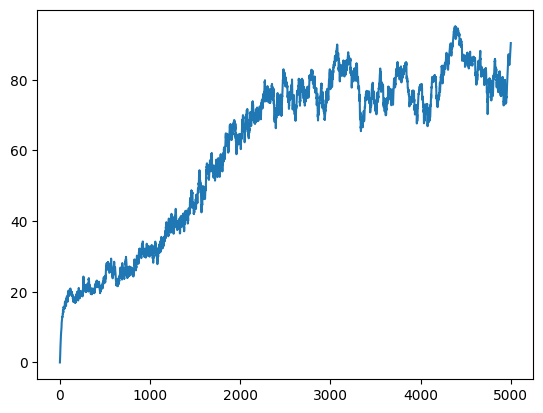

In [6]:
# In the new version of Gymnasium you need different environments for rendering and no rendering.
# Here we instaintiate two versions of cartpole, one that animates the episodes (which slows everything
# down), and another that does not animate.
env = gymnasium.make('CartPole-v1')
env_render = gymnasium.make('CartPole-v1', render_mode='human')

# Make a policy network.
policy = PolicyNet(env, inner=16)
baseline = BaselineNet(env, inner=16)

# Train the agent.
plt.plot(reinforce(policy, env, env_render, num_episodes=5000, gamma=0.99, baseline=False, comment='-NO-BASELINE-INNER=16'))

# Close up everything
env_render.close()
env.close()

In [15]:
# And run the final agent for a few episodes.
env_render = gymnasium.make('CartPole-v1', render_mode='human')
for _ in range(5):
    run_episode(env_render, policy)
env_render.close()

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


## For your consideration

There are many things that can be improved in this example. Some things you can think about:

1. **Replay**. In the current implementation we execute an episode, and then immediately run an optimization step on all of the steps of the episode. Not only are we using *correlated* samples from a single episode, we are decidedly *not* taking advantage of parallelism via batch gradient descent. Note that `REINFORCE` does **not** require entire trajectories, all we need are the discounted rewards and log probabilities for *individual transitions*.

2. **Exploration**. The model is probably overfitting (or perhaps remaining too *plastic*, which can explain the unstable convergence). Our policy is *always* stochastic in that we sample from the output distribution. It would be interesting to add a temperature parameter to the policy so that we can control this behavior, or even implement a deterministic policy sampler that always selects the action with max probability to evaluate the quality of the learned policy network.

3. **Discount Factor**: The discount factor (default $\gamma = 0.99$) is an important hyperparameter that has an effect on the stability of training. Try different values for $\gamma$ and see how it affects training. Can you think of other ways to stabilize training?